# Practical Deep Learning Workshop 2021
## Assignment 2 - Part 2 - Embeddings
 
### Authors:
 
1.   Chen Doytshman 205644941
2.   Naor Kolet 205533060


# 0. Imports

In [1]:
import pandas as pd
import numpy as np
 
# TensorFlow
from tensorflow.keras.layers import Input, Embedding,Flatten, Concatenate,Dropout
from tensorflow.keras.layers import BatchNormalization, Dense, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import LabelEncoder

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Misc.
import os
import joblib
import datetime
from tqdm import tqdm_notebook as tqdm
from multiprocessing import cpu_count

SEED = 42
%matplotlib inline

In [2]:
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [137]:
import py7zr

files = [f for f in os.listdir('input') if f.endswith('7z')]
for file in tqdm(files):
    with py7zr.SevenZipFile(f'input/{file}') as zf:
        zf.extractall('input')
        os.remove(f'input/{file}')

### 1.1 Data Description

We will be predicting the unit sales for thousands of items sold at different Favorita stores located in Ecuador. The training data includes dates, store and item information, whether that item was being promoted, as well as the unit sales. Additional files include supplementary information that may be useful in building your models.

### 1.2 Data Load

In this dataset we have several tables.
We will focus on the train & test tables and stores and items tables which includes general features.

In [3]:
train = pd.read_csv('input/train.csv', parse_dates=['date'])
train.date = train.date.astype('datetime64')
train.set_index('id', inplace=True)
train

/home/chendoy/.conda/envs/tf-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,date,store_nbr,item_nbr,unit_sales,onpromotion
id,,,,,
0,2013-01-01,25,103665,7.0,NaN
1,2013-01-01,25,105574,1.0,NaN
2,2013-01-01,25,105575,2.0,NaN
3,2013-01-01,25,108079,1.0,NaN
4,2013-01-01,25,108701,1.0,NaN
...,...,...,...,...,...
125497035,2017-08-15,54,2089339,4.0,False
125497036,2017-08-15,54,2106464,1.0,True
125497037,2017-08-15,54,2110456,192.0,False


In [4]:
stores = pd.read_csv('input/stores.csv')#, index_col='store_nbr')
stores.sample(5)

,store_nbr,city,state,type,cluster
19,20,Quito,Pichincha,B,6
49,50,Ambato,Tungurahua,A,14
48,49,Quito,Pichincha,A,11
12,13,Latacunga,Cotopaxi,C,15
44,45,Quito,Pichincha,A,11


In [5]:
items = pd.read_csv('input/items.csv')#, index_col='item_nbr')
items.sample(5)

,item_nbr,family,class,perishable
2083,1323422,GROCERY I,1003,0
1965,1239901,POULTRY,2420,1
1582,1091365,GROCERY I,1016,0
296,311994,BREAD/BAKERY,2752,1
149,210798,GROCERY I,1074,0


In [142]:
test = pd.read_csv('input/test.csv', parse_dates=['date'])
test.date = test.date.astype('datetime64')
test.set_index('id', inplace=True)
test

,date,store_nbr,item_nbr,onpromotion
id,,,,
125497040,2017-08-16,1,96995,False
125497041,2017-08-16,1,99197,False
125497042,2017-08-16,1,103501,False
125497043,2017-08-16,1,103520,False
125497044,2017-08-16,1,103665,False
...,...,...,...,...
128867499,2017-08-31,54,2132163,False
128867500,2017-08-31,54,2132318,False
128867501,2017-08-31,54,2132945,False


### 1.3 Preprocessing

We have several issues to direct in this step.
1. ```onpromotion``` field contains null values, we will consider them as False values
2. ```store_nbr```, ```item_nbr``` and ```onpromotion``` fields are categorical features - we will use LabelEncoder in order to convert the to indexed values (Also needed as preprocessing for Embeddings layers)

In [6]:
store_enc = LabelEncoder().fit(stores.store_nbr)
item_enc = LabelEncoder().fit(items.item_nbr)
prom_enc = LabelEncoder().fit([True, False])

In [7]:
def preprocess(df):
    df.onpromotion.fillna(False, inplace=True)
    df.store_nbr = store_enc.transform(df.store_nbr)
    df.item_nbr = item_enc.transform(df.item_nbr)
    df.onpromotion = prom_enc.transform(df.onpromotion)

In [8]:
preprocess(train)

In [145]:
preprocess(test)

Due to technical issues and guessing that data that is to far in the past we will only train on the last year.

In [9]:
df_2017 = train.loc[train.date >= datetime.datetime(2017,1,1)][['store_nbr', 'item_nbr', 'onpromotion', 'unit_sales']]

In [152]:
df_2017

,store_nbr,item_nbr,onpromotion,unit_sales
id,,,,
101688779,24,1,0,1.0
101688780,24,4,0,7.0
101688781,24,5,0,1.0
101688782,24,11,0,4.0
101688783,24,12,0,2.0
...,...,...,...,...
125497035,53,3990,0,4.0
125497036,53,3998,1,1.0
125497037,53,4003,0,192.0


## b. Solid Benchmark - Random Forest Regressor

In this section we will use Random Forest Regressor in order to make a basic solid benchmark.

We will use the three features mentioned earlier ```store_nbr```, ```item_nbr``` and ```onpromotion``` to predict the ```unit_sales```

In [153]:
def split_x_y(df=None, load_name=None, has_y=True):
    y = None
    if df is not None:
        x = df[['store_nbr', 'item_nbr', 'onpromotion']].values
        joblib.dump(x, f'objects/{load_name}_x.sav')
        if has_y:
            y = df['unit_sales'].values
            joblib.dump(y, f'objects/{load_name}_y.sav')
    else:
        x = joblib.load(f'objects/{load_name}_x.sav')
        if has_y:
            y = joblib.load(f'objects/{load_name}_y.sav')
    
    if has_y:
        return x, y
    return x

In [154]:
train_x, train_y = split_x_y(df=df_2017, load_name='train')

In [146]:
use_saved = True
rfr_path = 'models/rfr.sav'

if use_saved:
    rfr = joblib.load(rfr_path)
else:
    rfr = RandomForestRegressor(random_state=SEED, verbose=1, n_jobs=cpu_count())
    rfr.fit(train_x, train_y)
    joblib.dump(rfr, rfr_path)

#### Evaluation

In [155]:
train_score = rfr.score(train_x, train_y)
print(f'Got score of {train_score:.4f} according to the random forest score function on the train')

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:  2.7min finished


Got score of 0.4933 according to the random forest score function on the train


In [156]:
train_y_pred = rfr.predict(train_x)
train_mae = mean_absolute_error(train_y, train_y_pred)
print(f'Got MAE of {train_mae:.4f} on the train')

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:  2.2min finished


Got MAE of 3.8110 on the train


Generating results of the test to submit to kaggle

In [157]:
test_x = test[['store_nbr', 'item_nbr', 'onpromotion']].values
test_y_pred = rfr.predict(test_x)

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:   16.1s finished


In [158]:
def create_submission(y_pred, name='submit'):
    sub = pd.read_csv('input/sample_submission.csv')
    sub.set_index('id', inplace=True)
    sub['unit_sales'] = y_pred
    # Kaggle do not accept negative values, so if such values exist; we will zero them
    sub[sub['unit_sales'] < 0] = 0
    sub.to_csv(f'results/{name}.csv')

In [176]:
create_submission(test_y_pred, 'rfr')

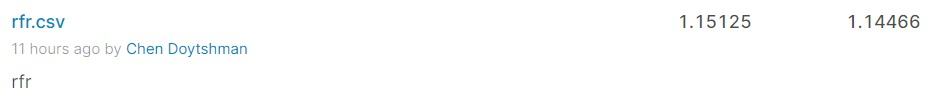

## c. Preprocessing Steps to Create an Embedding 

Please refer to the section 1.3 preprocessing as no fmore preprocessing are needed for the task as we already indexed the features we want to feed to the Embeddings layers.

## d. Predicting the target using only the features embeddings 

In [186]:
def get_callbacks(model_name):
    acc = 'val_loss'
    acc_mode = 'min'
    
    checkpoint = ModelCheckpoint(
                              fr'./models/{model_name}.h5', 
                              monitor=acc, 
#                               verbose=1, 
                              save_best_only=True, 
                              mode=acc_mode)
    earlystop = EarlyStopping(monitor=acc, mode=acc_mode, verbose=1, patience=4)
    reduceLR = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = 3,
                            factor = 0.5, min_lr = 1e-6, verbose = 1)

    return [checkpoint, reduceLR, earlystop]

In [13]:
def train_model(model_gen, args=None, batch_size=8192, use_saved=False):
    os.makedirs('./models', exist_ok=True)
    model_name = model_gen.__name__[5:]
    global train
    
    if args:
        train, val = args
        
    if use_saved:
        history = joblib.load(fr'./models/{model_name}_history.sav')
    else:
        callbacks = get_callbacks(model_name)
            
        history = model_gen().fit(x=[df_2017.store_nbr, df_2017.item_nbr, df_2017.onpromotion],
                    y=df_2017.unit_sales,
                    batch_size=batch_size,
                    epochs=20,
                    validation_split=0.3,
                    callbacks=callbacks
                    )
        
        history = history.history
        joblib.dump(history, fr'./models/{model_name}_history.sav')
    
    model = load_model(fr'./models/{model_name}.h5')
    
    return model, history

Now we will create our first embeddings model. We will use first embeddings to the features: ```store_nbr```, ```item_nbr``` and ```onpromotion```.
Each embeddings will contains 5 numbers and we saw that adding one seperated embeddings as bias improved the results.

We will than combine all the embeddings and continue with a regular network

In [15]:
def init_model_v1(n_factors=5):
    store_in = Input(shape=(1,), dtype='int64', name='store_in')
    s = Embedding(len(store_enc.classes_), n_factors, input_length=1, embeddings_regularizer=l2(1e-4),)(store_in)
    s = Flatten()(s)
    item_in = Input(shape=(1,), dtype='int64', name='item_in')
    i = Embedding(len(item_enc.classes_), n_factors, input_length=1, embeddings_regularizer=l2(1e-4),)(item_in)
    i = Flatten()(i)
    prom_in = Input(shape=(1,), dtype='int64', name='prom_in')
    p = Embedding(len(prom_enc.classes_), n_factors, input_length=1, embeddings_regularizer=l2(1e-4),)(prom_in)
    p = Flatten()(p)

    def create_bias(inp, n_in):
        X = Embedding(n_in, 1, input_length=1)(inp)
        return Flatten()(X)


    sb = create_bias(store_in, len(store_enc.classes_))
    ib = create_bias(item_in, len(item_enc.classes_))
    pb = create_bias(prom_in, len(prom_enc.classes_))

    X = Concatenate()([s, i, p, sb, ib, pb])
    X = Dense(64,activation='relu')(X)
    X = BatchNormalization()(X)
    X = Dropout(0.4)(X)
    X = Dense(32,activation='relu')(X)
    X = Dropout(0.3)(X)
    X = Dense(16,activation='relu')(X)
    X = Dense(1,activation='relu')(X)

    model = Model([store_in, item_in, prom_in], X)
    model.compile(Adam(0.001), loss='mse', metrics=['mae'])
    
    return model

In [189]:
init_model_v1().summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
store_in (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_in (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
prom_in (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_33 (Embedding)        (None, 1, 5)         270         store_in[0][0]                   
____________________________________________________________________________________________

In [16]:
model_v1, history_v1 = train_model(init_model_v1, use_saved=True)

In [166]:
def visualize_perf(h):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    fig.suptitle(f'Model performance over epochs')

    for k in ['loss', 'val_loss']:
        ax[0].plot(h[k])
        ax[0].legend(['train_loss', 'val_loss'])
        ax[0].margins(0.02)
        ax[0].set_title(f'Loss')

    for k in ['mae', 'val_mae']:
        ax[1].plot(h[k])
        ax[1].legend(['train_mae', 'val_mae'])
        ax[1].margins(0.02)
        ax[1].set_title(f'MAE')

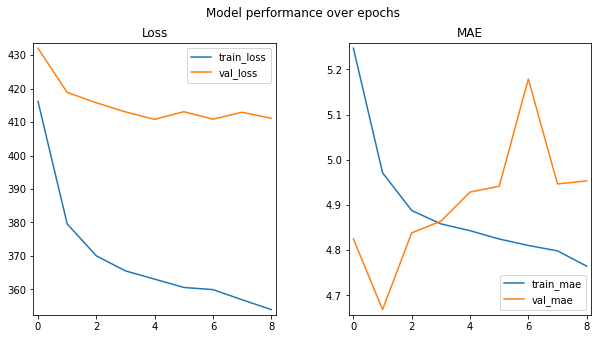

In [191]:
visualize_perf(history_v1)

In [192]:
train_y_pred = model_v1.predict([df_2017.store_nbr, df_2017.item_nbr, df_2017.onpromotion])
train_mae = mean_absolute_error(df_2017.unit_sales, train_y_pred)
print(f'Got MAE of {train_mae:.4f} on the train')

Got MAE of 4.8233 on the train


In [193]:
test_x = [test.store_nbr, test.item_nbr, test.onpromotion]
test_y_pred = model_v1.predict(test_x)

In [194]:
create_submission(test_y_pred, 'model_v1')

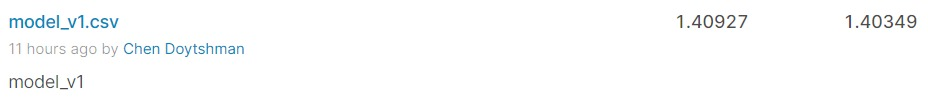

## e. Adding more features and a time-series approach

Now we will use LSTM network to better model the time series part of the problem.
We will use a lookback of 4.
to combine the embeddings layers with the lstm, each timeseries will contain the discrete values of the fields. Then it will go through the embeddings layer generating for each discrete value its corresponding five length embeddings.

In [208]:
def prepare_data_lstm(df, look_back=4, with_y=True):
    x = np.ascontiguousarray(df[['store_nbr','item_nbr','onpromotion']].values)
    as_strided = np.lib.stride_tricks.as_strided
    l0, l1 = x.shape
    s0, s1 = x.strides
    x = as_strided(x, (l0-look_back+1,look_back,l1), (s0, s1 * l1, s1))
    
    if with_y:
        y = df['unit_sales'].iloc[look_back-1:]
        return x, y
    
    return x
    
look_back = 4
x, y = prepare_data_lstm(df_2017, look_back=look_back)
x.shape, y.shape

((23808258, 4, 3), (23808258,))

In [170]:
def init_lstm_model(look_back=4, n_factors=5):
    
    store_in = Input(shape=(look_back,), dtype='int64', name='store_in')
    s = Embedding(len(store_enc.classes_), n_factors, input_length=look_back, embeddings_regularizer=l2(1e-4),)(store_in)
    item_in = Input(shape=(look_back,), dtype='int64', name='item_in')
    i = Embedding(len(item_enc.classes_), n_factors, input_length=look_back, embeddings_regularizer=l2(1e-4),)(item_in)
    prom_in = Input(shape=(look_back,), dtype='int64', name='prom_in')
    p = Embedding(len(prom_enc.classes_), n_factors, input_length=look_back, embeddings_regularizer=l2(1e-4),)(prom_in)
    
    X = Concatenate(axis=2)([s, i, p])
    X = LSTM(32, input_shape=(look_back, n_factors))(X)
    X = Dropout(0.2)(X)
    X = Dense(32)(X)
    X = Dropout(0.3)(X)
    X = Dense(1)(X)
    
    model = Model(inputs=[store_in, item_in, prom_in], outputs=X)
    model.compile(loss = 'mse', optimizer='adam', metrics=['mae'])
    
    return model

In [171]:
lstm_model = init_lstm_model(look_back)
lstm_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
store_in (InputLayer)           [(None, 4)]          0                                            
__________________________________________________________________________________________________
item_in (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
prom_in (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
embedding_30 (Embedding)        (None, 4, 5)         270         store_in[0][0]                   
____________________________________________________________________________________________

In [82]:
inputs = [x[:,:,0], x[:,:,1], x[:,:,2]]

history = lstm_model.fit(x=inputs,
                         y=y,
                         batch_size=128,
                         epochs=20,
                         validation_split=0.3,
                         callbacks=get_callbacks('lstm'))

Epoch 1/20
130202/130202 [==============================] - 754s 6ms/step - loss: 375.5840 - mae: 4.8835 - val_loss: 437.0956 - val_mae: 5.0741 - lr: 0.0010
Epoch 2/20
130202/130202 [==============================] - 766s 6ms/step - loss: 360.3687 - mae: 4.7977 - val_loss: 465.7905 - val_mae: 5.1037 - lr: 0.0010
Epoch 3/20
130202/130202 [==============================] - 762s 6ms/step - loss: 356.7563 - mae: 4.7695 - val_loss: 493.5514 - val_mae: 5.0674 - lr: 0.0010
Epoch 4/20
130197/130202 [============================>.] - ETA: 0s - loss: 354.6024 - mae: 4.7708
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
130202/130202 [==============================] - 766s 6ms/step - loss: 354.5935 - mae: 4.7708 - val_loss: 539.0582 - val_mae: 5.2827 - lr: 0.0010
Epoch 5/20
130202/130202 [==============================] - 767s 6ms/step - loss: 350.9425 - mae: 4.7167 - val_loss: 568.4625 - val_mae: 5.3324 - lr: 5.0000e-04
Epoch 00005: early stopping


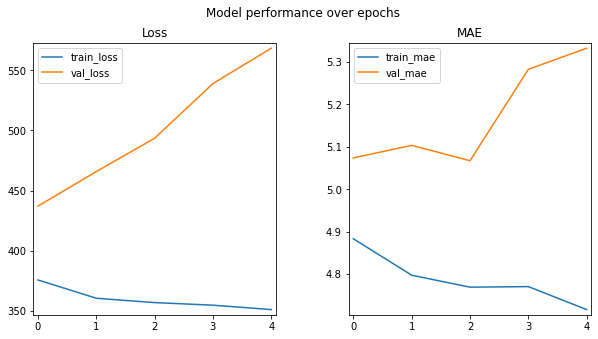

In [87]:
visualize_perf(history.history)

In [175]:
train_y_pred = lstm_model.predict([x[:,:,0], x[:,:,1], x[:,:,2]])
train_mae = mean_absolute_error(y, train_y_pred)
print(f'Got MAE of {train_mae:.4f} on the train')

Got MAE of 4.7828 on the train


In [214]:
test_x = prepare_data_lstm(pd.concat([df_2017.tail(3), test], axis=0), with_y=False)
test_y_pred = lstm_model.predict([test_x[:,:,0], test_x[:,:,1], test_x[:,:,2]])

In [215]:
create_submission(test_y_pred, 'lstm')

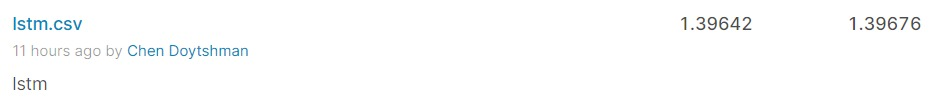

## f. Interesting insights from embeddings

Here we will try to elucidate useful information from the embeddings we calculated from the store and item ids.

First we will take the embeddings layers from the previous model with its weights and use it to calculate the embeddings of each store and item in the train dataset.

In [17]:
embedding_creator = Model(
    inputs = [l.input for l in model_v1.layers[:3]],
    outputs = [l.output for l in model_v1.layers[3:6]]
)

embedding_creator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
store_in (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_in (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
prom_in (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_39 (Embedding)        (None, 1, 5)         270         store_in[0][0]                   
______________________________________________________________________________________________

In [18]:
s = df_2017['store_nbr'].values
i = df_2017['item_nbr'].values
m = df_2017['onpromotion'].values

In [19]:
s_e, i_e, p_e = embedding_creator.predict([s, i, m])

In [20]:
target = df_2017['unit_sales'].values

In [21]:
s_e = s_e.reshape(s_e.shape[0],-1)
i_e = i_e.reshape(i_e.shape[0],-1)
p_e = p_e.reshape(p_e.shape[0],-1)

Now we will plot the sales values as a function of the embeddings values in order to try to see the correlation between the two.

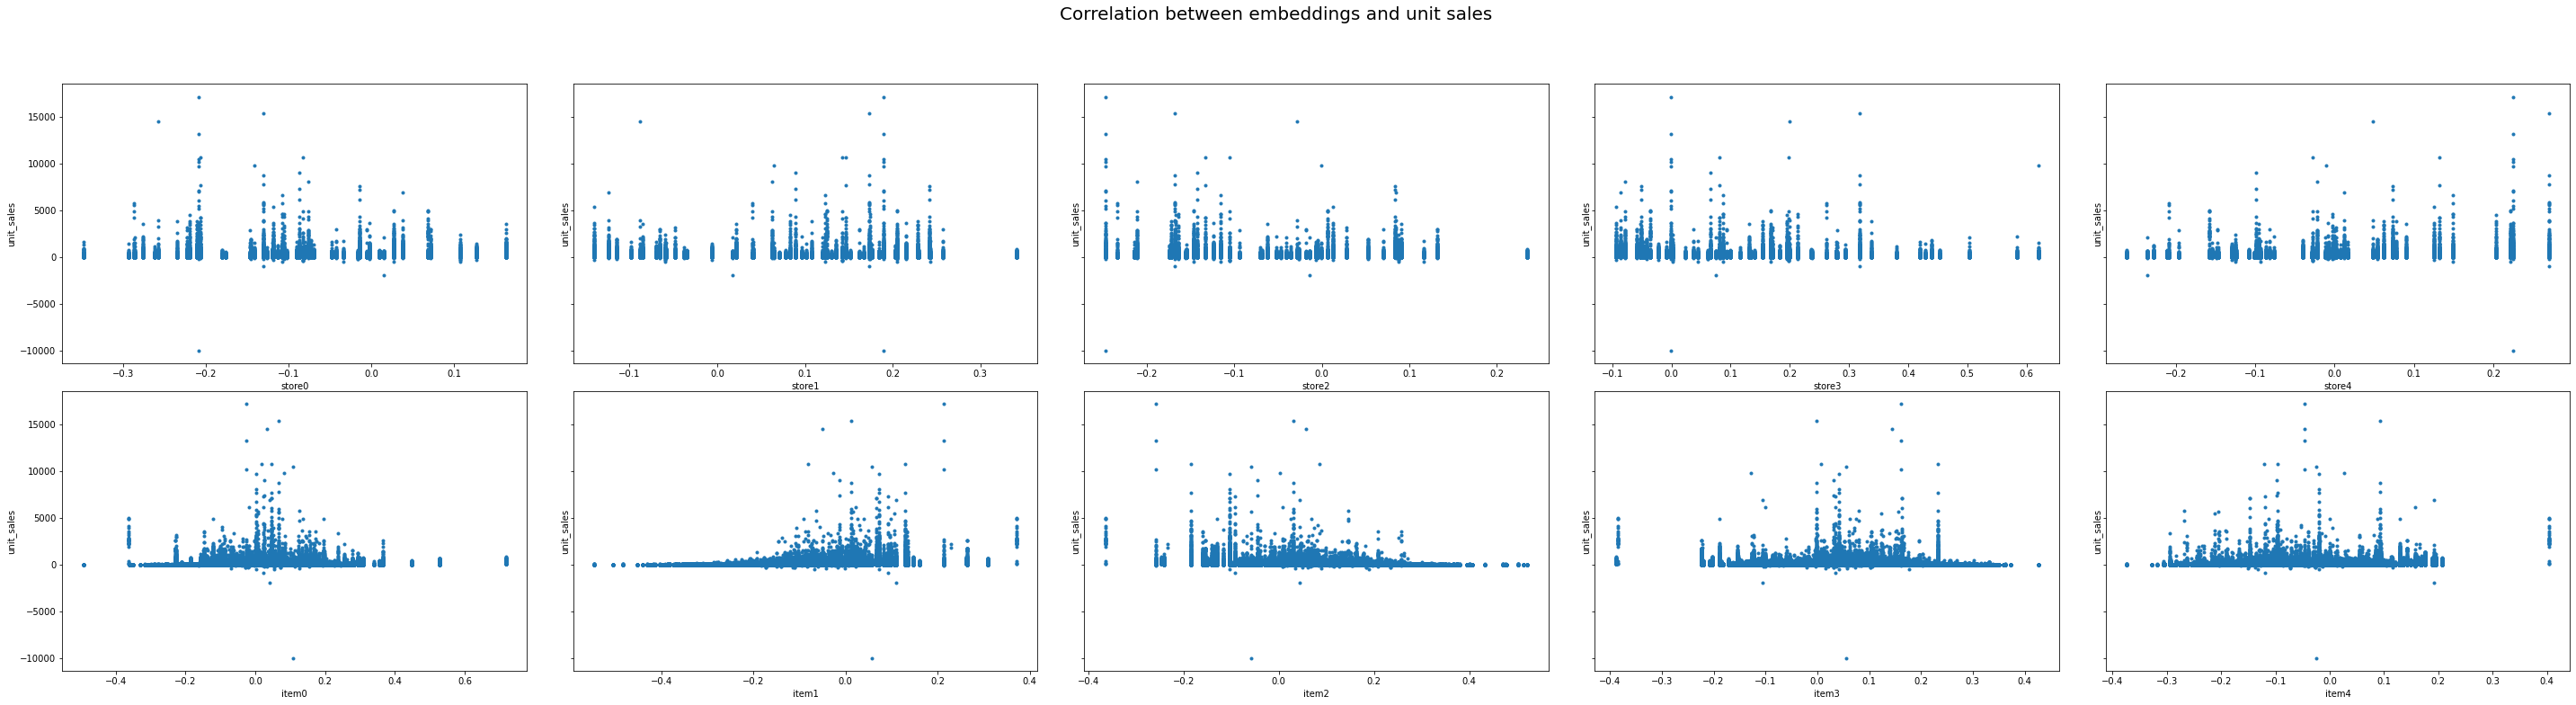

In [22]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10*5,6*2), sharey=True)
fig.subplots_adjust(hspace=0.1, wspace=0.1)
fig.suptitle(f'Correlation between embeddings and unit sales', fontsize = 20)

xlabel = ['store', 'item']
for i, ef in enumerate([s_e, i_e]):
    for j in range(5):
        ax[i][j].plot(ef[:,j], target, '.')
        ax[i][j].set_xlabel(f'{xlabel[i]}{j}')
        ax[i][j].set_ylabel('unit_sales')
        
plt.show()

In the above plot, the first row plots the store's embeddings and the second row plots the item's embeddings. We will number the embeddings from zero to four from left to right as the embeddings contains five places.

We will now note the correlations that can be seen from the above plots:
- Negative correlation: store2, store3, item2.
- Positive correlation: store4, item1.
- item0, item3 and item4 gets values arround 0 the sales are very likely to be high.

## g. Using embeddings as a “feature extractor” for classical ML

Here we will use the embeddings layers as "feature extractor". We will convert the features to their embeddings representation and feed it to a Decision Tree Regressor

In [131]:
from sklearn.tree import DecisionTreeRegressor

s_e, i_e, p_e = embedding_creator.predict([s, i, m])
target = df_2017['unit_sales'].values

embed_input = np.concatenate([s_e, i_e, p_e], axis=1)
embed_input = embed_input.reshape(embed_input.shape[0], -1)

dtr_model = DecisionTreeRegressor()
dtr_model.fit(embed_input, target)


DecisionTreeRegressor()

In [185]:
train_score = dtr_model.score(embed_input, target)
print(f'Got score of {train_score:.4f} according to the decision tree regression score function on the train')

Got score of 0.4180 according to the decision tree regression score function on the train


In [178]:
train_y_pred = dtr_model.predict(embed_input)
train_mae = mean_absolute_error(target, train_y_pred)
print(f'Got MAE of {train_mae:.4f} on the train')

Got MAE of 4.0974 on the train


Generating results of the test to submit to kaggle

In [183]:
test_x = [test.store_nbr, test.item_nbr, test.onpromotion]
test_s_e, test_i_e, test_p_e = embedding_creator(test_x)
test_x = np.concatenate([test_s_e, test_i_e, test_p_e], axis=1)
test_x = test_x.reshape(test_x.shape[0], -1)

test_y_pred = dtr_model.predict(test_x)

In [184]:
create_submission(test_y_pred, 'dtr_embed')

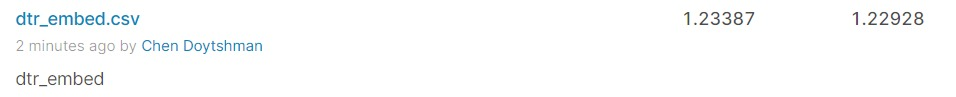